# Get started

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/101-get_started.ipynb)

This notebook contains the simple examples of time series forecasting pipeline
using ETNA library.

**Table of contents**

* [Loading dataset](#chapter1)
* [Plotting](#chapter2)
* [Forecasting single time series](#chapter3)
    * [Naive forecast](#section_3_1)
    * [Prophet](#section_3_2)
    * [Catboost](#section_3_3)
* [Forecasting multiple time series](#chapter4)

In [1]:
!pip install "etna[prophet]" -q

In [2]:
import warnings

import pandas as pd

## 1. Loading dataset <a class="anchor" id="chapter1"></a>

Let's load and look at the dataset

In [3]:
df = pd.read_csv("data/monthly-australian-wine-sales.csv")
df.head()

,month,sales
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


Library works with a special data structure called `TSDataset`. It stores all the necessary information to work with multiple time series.

To create an instance of `TSDataset` we should reformat our `df` into one of two supported formats:

- Long format
  - Has columns `timestamp`, `segment`, `target`
  - Column `timestamp` stores timestamp values
  - Column `target` stores values of time series
  - Column `segment` stores identifiers of different time series
- Wide format
  - Index stores timestamp values
  - Columns has two levels with names 'segment', 'feature'. Each column stores values for a given feature in a given segment.

More details about the formats could be found in documentation for `etna.datasets.DataFrameFormat`.

Usually it is much easier to create dataframe in a long format. So, let's do it!

In [4]:
df["timestamp"] = pd.to_datetime(df["month"])
df["target"] = df["sales"]
df.drop(columns=["month", "sales"], inplace=True)
df["segment"] = "main"
df.head()

,timestamp,target,segment
0,1980-01-01,15136,main
1,1980-02-01,16733,main
2,1980-03-01,20016,main
3,1980-04-01,17708,main
4,1980-05-01,18019,main


To get a wide format from a long format the `TSDataset.to_dataset` could be used:

In [5]:
from etna.datasets.tsdataset import TSDataset

wide_df = TSDataset.to_dataset(df)
wide_df.head()

segment,main
feature,target
timestamp,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


Time to create a `TSDataset`! Additionally to passing a dataframe we should specify the frequency of our data. \
Our library implements 2 ways to do this:
1. Using [`pd.DataOffsets` objects](https://pandas.pydata.org/docs/user_guide/timeseries.html#dateoffset-objects)
2. Using [offset aliases](https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases)

Both methods give the same result, but be careful, sometimes aliases are different for different versions `pandas`. We recommend using the first variant.

In our case, it is monthly data at the beginning of the month. Let's look at both options:

In [6]:
# 1. Use pd.offsets
from pandas.tseries.offsets import MonthBegin

ts = TSDataset(df, freq=MonthBegin(1))

# 2. Use offset alias
ts = TSDataset(df, freq="1MS")

If you accidentally set the wrong data frequency, you will get a warning, for example:

In [7]:
wrong_freq_ts = TSDataset(df, freq="D")

/Users/d.d.smorchkov/PycharmProjects/etna/etna/datasets/tsdataset.py:364: UserWarning: You probably set wrong freq. Discovered freq in you data is MS, you set D
  warnings.warn(


Okay, now we can look at the basic information about the dataset

In [8]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          1980-01-01    1994-08-01     176            0


Or in `DataFrame` format

In [9]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,1980-01-01,1994-08-01,176,0,1,0,0,0,MS


Library also has several internal public datasets. You can use them to compare some models with public benchmarks. It is easy to use:

In [10]:
from etna.datasets import load_dataset

ts = load_dataset(name="australian_wine_sales_monthly")

ts.head()

segment,main
feature,target
timestamp,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


You can get the full list of available internal datasets:

In [11]:
from etna.datasets.internal_datasets import list_datasets

print(list_datasets())

['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2', 'IHEPC_T', 'australian_wine_sales_monthly', 'electricity_15T', 'm3_monthly', 'm3_other', 'm3_quarterly', 'm3_yearly', 'm4_daily', 'm4_hourly', 'm4_monthly', 'm4_quarterly', 'm4_weekly', 'm4_yearly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'traffic_2008_10T', 'traffic_2008_hourly', 'traffic_2015_hourly', 'weather_10T']


More information about internal datasets can be found in this [documentation page](https://docs.etna.ai/stable/internal_datasets.html).

## 2. Plotting <a class="anchor" id="chapter2"></a>

Let's take a look at the time series in the dataset

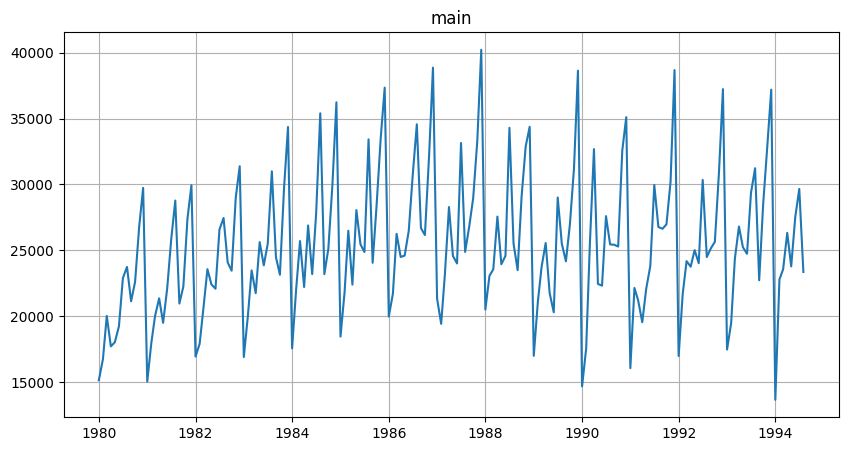

In [12]:
ts.plot()

## 3. Forecasting single time series <a class="anchor" id="chapter3"></a>

Our library contains a wide range of different models for time series forecasting. Let's look at some of them.

In [13]:
warnings.filterwarnings("ignore")

Let's predict the monthly values in 1994 for our dataset.

In [14]:
HORIZON = 8

In [15]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

### 3.1 Naive forecast <a class="anchor" id="section_3_1"></a>

We will start by using the `NaiveModel` that just takes the value from `lag` time steps before.

This model doesn't require any features, so to make a forecast we should define pipeline with this model and set a proper horizon value.

In [16]:
from etna.models import NaiveModel
from etna.pipeline import Pipeline

# Define a model
model = NaiveModel(lag=12)

# Define a pipeline
pipeline = Pipeline(model=model, horizon=HORIZON)

Let's make a forecast.

In [17]:
# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

Calling `pipeline.forecast` without parameters makes a forecast for the next `HORIZON` points after the end of the training set.

In [18]:
forecast_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          1994-01-01    1994-08-01       8            0


Now let's look at the result metric and plot the prediction. All the methods already built-in in ETNA.

In [19]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 11.492045838249387}

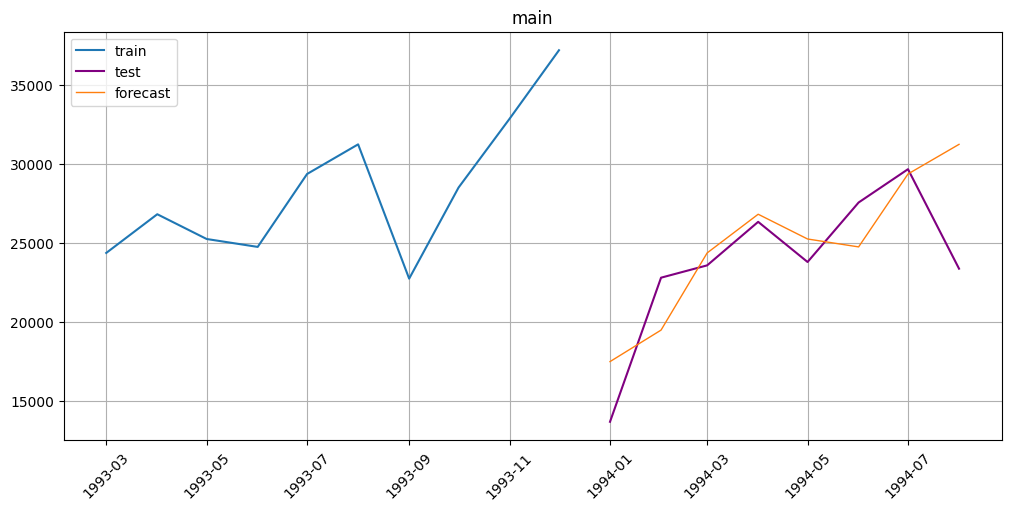

In [20]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=10)

### 3.2 Prophet<a class="anchor" id="section_3_2"></a>

Now we can try to improve the forecast by using Prophet model.

In [21]:
from etna.models import ProphetModel

# Define a model
model = ProphetModel()

# Define a pipeline
pipeline = Pipeline(model=model, horizon=HORIZON)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

18:15:32 - cmdstanpy - INFO - Chain [1] start processing
18:15:32 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.533082049402035}

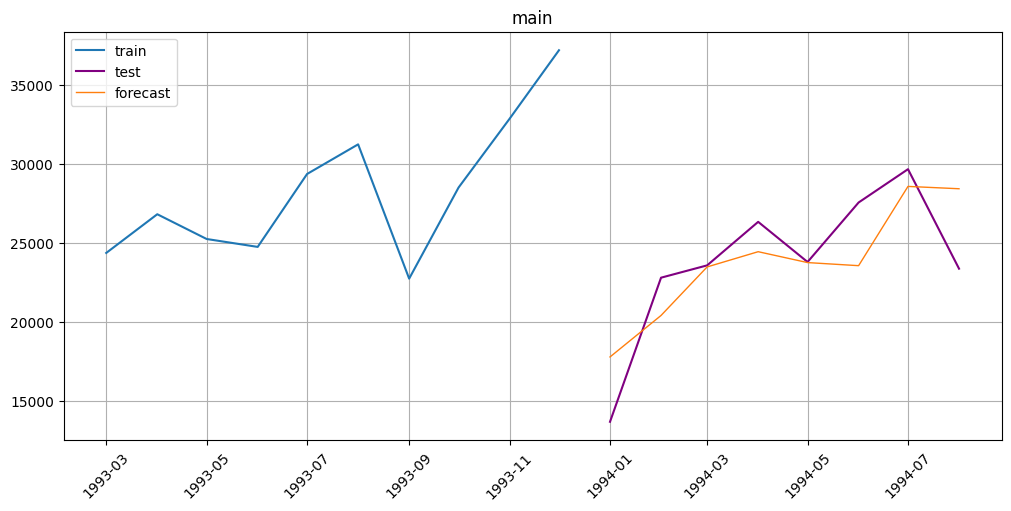

In [23]:
plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=10)

### 3.3 Catboost <a class="anchor" id="section_3_3"></a>

Finally, let's try the ML-model. This kind of models require some features to make a forecast. 

#### 3.3.1 Basic transforms

ETNA has a wide variety of transforms to work with data, let's take a look at some of them.

**Lags**

Lag transformation is the most basic one. It gives us some previous value of the time series. For example, the first lag is the previous value, and the fifth lag is the value five steps ago. Lags are essential for regression models, like linear regression or boosting, because they allow these models to grasp information about the past.

The scheme of working:

![lags-scheme](./assets/get_started/lags.gif)

In [24]:
from etna.transforms import LagTransform

lags = LagTransform(in_column="target", lags=list(range(HORIZON, 24)), out_column="lag")

There are some limitations on available lags during the forecasting. Imagine that we want to make a forecast for 3 step ahead. We can't take the previous value when we make a forecast for the last step, we just don't know the value. For this reason, you should use `lags` >= `HORIZON` when using a `Pipeline`.

**Statistics**

Statistics are another essential feature. It is also useful for regression models as it allows them to look at the information about the past but in different ways than lags. There are different types of statistics: mean, median, standard deviation, minimum and maximum on the interval.

The scheme of working:

![statistics-scheme](./assets/get_started/statistics.gif)

As we can see, the window includes the current timestamp. For this reason, we shouldn't apply the statistics transformations to target variable, we should apply it to lagged target variable.

In [25]:
from etna.transforms import MeanTransform

mean = MeanTransform(in_column=f"lag_{HORIZON}", window=12)

**Dates**

The time series also has the timestamp column that we have not used yet. But date number in a week and in a month, as well as week number in year or weekend flag can be really useful for the machine learning model. And ETNA allows us to extract all this information with `DateFlagTransform`.

In [26]:
from etna.transforms import DateFlagsTransform

date_flags = DateFlagsTransform(
    day_number_in_week=False,
    day_number_in_month=False,
    week_number_in_month=False,
    month_number_in_year=True,
    season_number=True,
    is_weekend=False,
    out_column="date_flag",
)

**Logarithm**

However, there is another type of transform that alters the column itself. We call it “inplace transform”. The easiest is `LogTransform`. It logarithms values in a column.

In [27]:
from etna.transforms import LogTransform

log = LogTransform(in_column="target", inplace=True)

#### 3.3.2 Forecasting

Now let's pass these transforms into our `Pipeline`. It will do all the work with applying the transforms and making exponential inverse transformation after the prediction.

In [28]:
from etna.models import CatBoostMultiSegmentModel

# Define transforms
transforms = [lags, mean, date_flags, log]

# Define a model
model = CatBoostMultiSegmentModel()

# Define a pipeline
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

In [29]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.78610453770036}

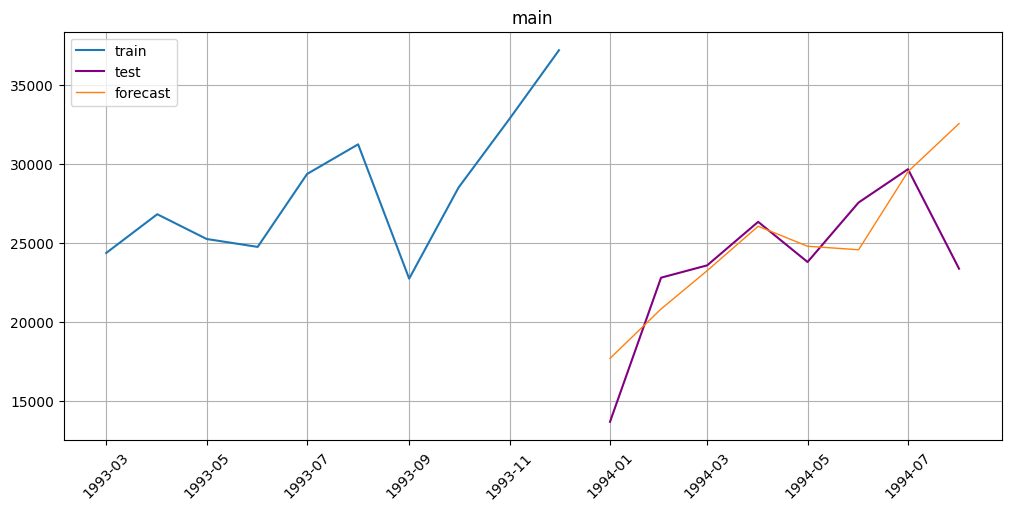

In [30]:
plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=10)

## 4. Forecasting multiple time series <a class="anchor" id="chapter4"></a>

In this section you may see example of how easily ETNA works with multiple time series and get acquainted with other transforms the library contains.

In [31]:
HORIZON = 30

In [32]:
df = pd.read_csv("data/example_dataset.csv")
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


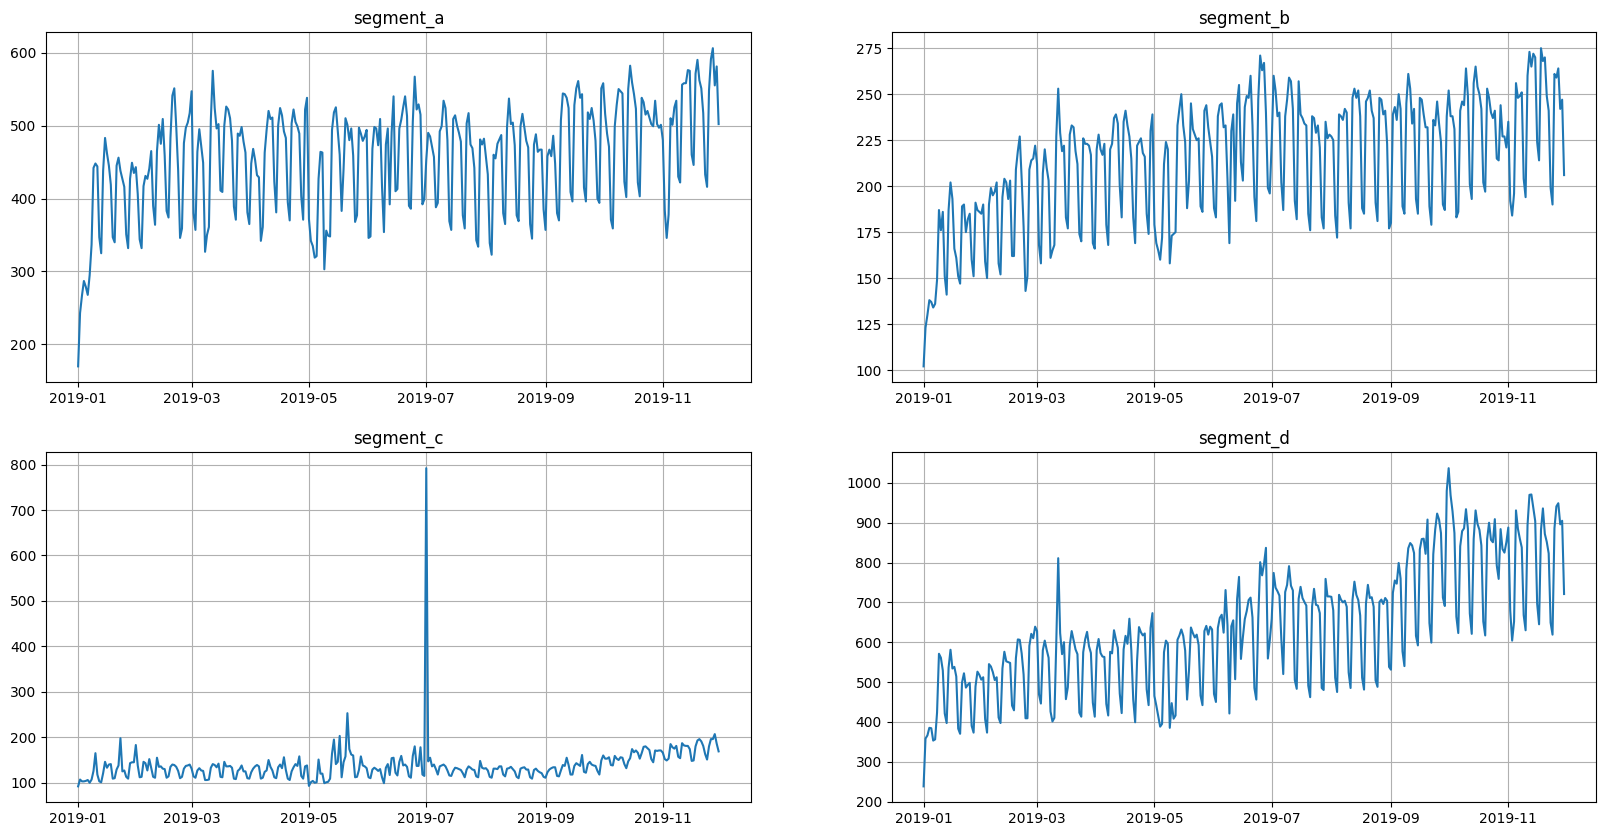

In [33]:
ts = TSDataset(df, freq="D")
ts.plot()

In [34]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-01-01    2019-11-30     334            0
segment_b      2019-01-01    2019-11-30     334            0
segment_c      2019-01-01    2019-11-30     334            0
segment_d      2019-01-01    2019-11-30     334            0


In [35]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

In [36]:
test_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-11-01    2019-11-30      30            0
segment_b      2019-11-01    2019-11-30      30            0
segment_c      2019-11-01    2019-11-30      30            0
segment_d      2019-11-01    2019-11-30      30            0


In [37]:
from etna.transforms import LinearTrendTransform
from etna.transforms import SegmentEncoderTransform

# Define transforms
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 96)), out_column="lag")
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    is_weekend=True,
)
mean = MeanTransform(in_column=f"lag_{HORIZON}", window=30)
transforms = [log, trend, lags, date_flags, seg, mean]

# Define a model
model = CatBoostMultiSegmentModel()

# Define a pipeline
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

In [38]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_a': 6.146211495853116,
 'segment_b': 5.912030620420745,
 'segment_c': 11.833167344191255,
 'segment_d': 5.026194101393468}

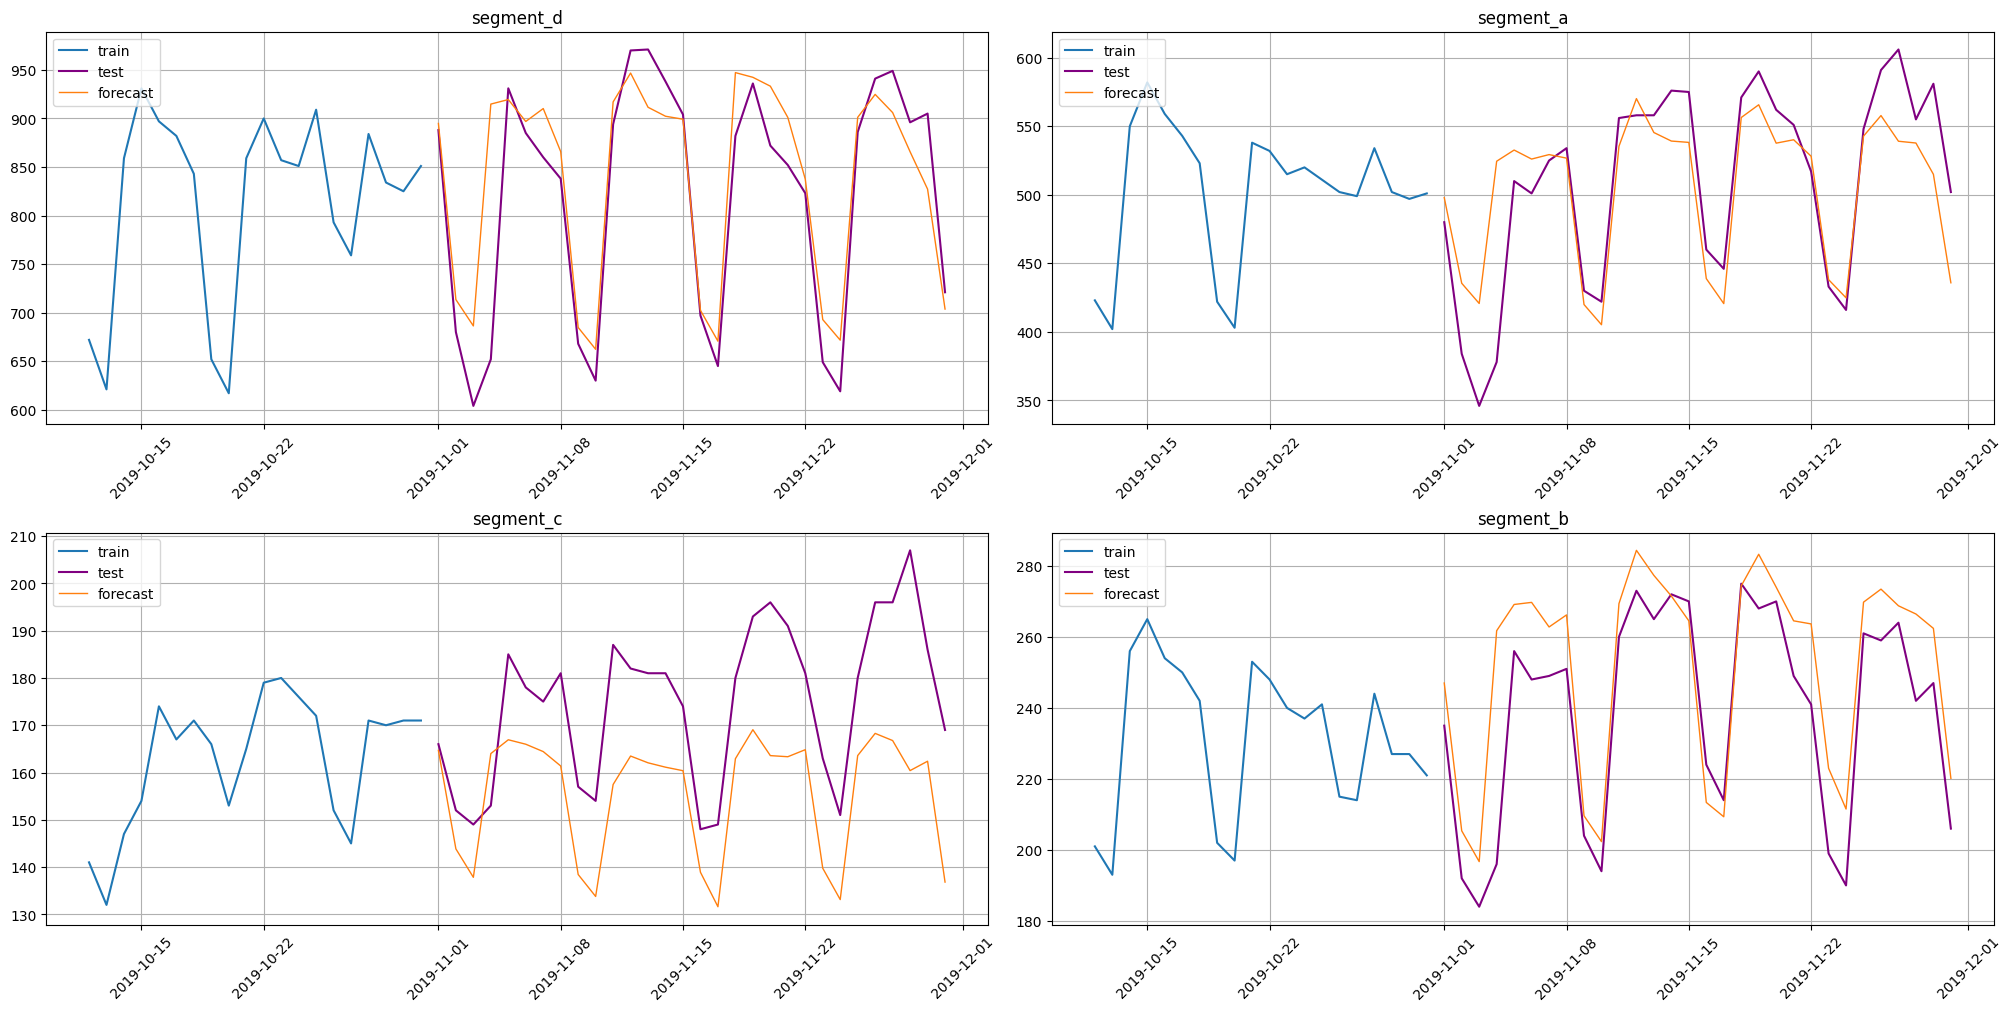

In [39]:
plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=20)